# The Results of RL approach

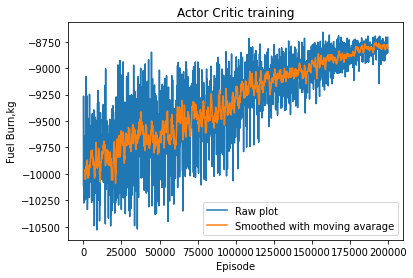

In [2]:
import pandas as pd
import numpy as np
df1 = pd.read_csv('saved_results/run-May31_18-29-24_hyperion-tag-EpisodeFuel.csv')
df2 = pd.read_csv('saved_results/run-May31_18-40-25_hyperion-tag-EpisodeFuel.csv')

import matplotlib.pyplot as plt
plt.ylabel('Fuel Burn,kg')
plt.xlabel('Episode')
plt.title("Actor Critic training")

plt.plot(np.linspace(0, 200000, len(np.concatenate([df1["Value"].values, df2["Value"].values]))), pd.Series(np.concatenate([df1["Value"].values, df2["Value"].values])).rolling(window =1).mean(), label='Raw plot')
plt.plot(np.linspace(0, 200000, len(np.concatenate([df1["Value"].values, df2["Value"].values]))), pd.Series(np.concatenate([df1["Value"].values, df2["Value"].values])).rolling(window =10).mean(), label='Smoothed with moving avarage')
plt.legend()
plt.show()
# plt.plot(df2['Value'])
# plt.savefig('A2C.png',bbox_inches='tight')

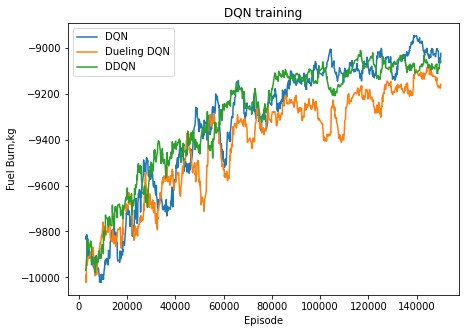

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,5)

df = pd.read_csv('saved_results/run-May31_15-17-50_hyperion-tag-EpisodeFuel.csv')
df_dqn = pd.read_csv('saved_results/run-Jun01_10-10-29_hyperion-tag-EpisodeFuel.csv')
df_ddqn = pd.read_csv('saved_results/run-Jun01_11-23-41_hyperion-tag-EpisodeFuel.csv')
df_doubledqn = pd.read_csv('saved_results/run-Jun01_14-34-59_hyperion-tag-EpisodeFuel.csv')
plt.title("DQN training")
plt.ylabel('Fuel Burn,kg')
plt.xlabel('Episode')
plt.plot(df_dqn["Step"], pd.Series(df_dqn["Value"]).rolling(window =20).mean(), label='DQN')
plt.plot(df_ddqn["Step"],pd.Series(df_ddqn["Value"]).rolling(window =20).mean(), label='Dueling DQN')
plt.plot(df_doubledqn["Step"],pd.Series(df_doubledqn["Value"]).rolling(window =20).mean(), label='DDQN')
plt.legend()
plt.show()
# plt.savefig('dqn.png')
# plt.plot()
# plt.savefig('QTable-plot.png',bbox_inches='tight')

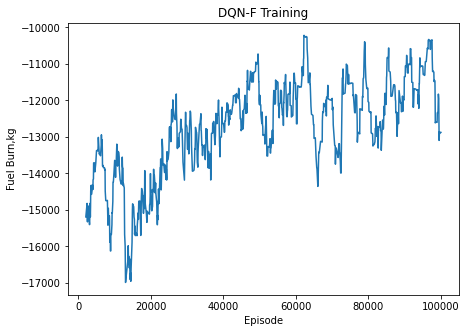

In [5]:
dqnf = pd.read_csv('saved_results/run-Jun01_15-29-13_hyperion-tag-EpisodeFuel.csv')
plt.title("DQN-F Training")
plt.plot(dqnf["Step"],pd.Series(dqnf["Value"]).rolling(window =20).mean(), label='DDQN')
plt.ylabel('Fuel Burn,kg')
plt.xlabel('Episode')
# plt.savefig('dqnf.png')
plt.show()

# Simulating dynamic environment

In [6]:
import random
%load_ext autoreload
%autoreload 2
from aircraft_env import Location
from aircraft_env import AircraftEnv
from utils.env_extra import env_summary
loc_1 = Location(45.46873715, -73.74257166095532)
loc_2 = Location(49.0068908, 2.5710819691019156)
env = AircraftEnv(arrival_location=loc_1, destination=loc_2, n_waypoints=9)

# np.arange
import time
start = time.time()
js = []
for k in range(100):
    j = np.full((5, 9), env.cruise_alt_max)
    ls = []
    l = random.choices(np.arange(8), weights=[0, 0, 0, 80, 80, 70, 60, 80])[0]
    ls.append(l)
    dct = {}
    st = set()
    for i in range(l):
        while True:
            trajectory = np.random.randint(5)
            wp = np.random.randint(9)
            if (trajectory, wp) in st:
                continue
            if wp in dct:
                if dct[wp] == 4:
                    continue
                dct[wp] += 1
            dct[wp] = 1
            st.add((trajectory, wp))
#             print(j[trajectory], trajectory)
            j[trajectory, wp] = np.random.uniform(env.cruise_alt_min, env.cruise_alt_max - 400)
            
            
            break
    js.append(j)
print(time.time() - start)

0.01412653923034668


# Define greedy agent

In [7]:
from aircraft_env import feet2meter
from itertools import product
class GreedyAgent:
    def __init__(self, env):
        self.actions = list(product(
            np.arange(env.n_routes),
            np.array(list(map(feet2meter, np.arange(-2000, 3000, 1000)))),
            np.arange(env.cruise_mach_range[0], env.cruise_mach_range[-1], 0.01)
        ))
        self.env = env
    def preprocess_action(self, action):
        return {
            "trajectory": int(action[0]),
            "altitude": action[1],
            "mach_number": action[2]
        }
    def best_action(self, state, env):
        best_reward = -20000
        best_action = None
        
        for action in self.actions:
#             print(action)
            processed_action = self.preprocess_action(action)
#             print(processed_action)
            reward, done = env.act(processed_action)
            if reward > best_reward:
                best_reward = reward
                best_action = processed_action
        return best_action

# Define solver agent

In [9]:
n = env.n_waypoints - 1
def aicraft_problem(x):
    env.reset()
    i = 0
    n = env.n_waypoints - 1
    
    for i in range(n):
        
        action = {}
        
        action['trajectory'] = int(np.round(x[n + 5*n + i]))
        ai = n + 5*i
        action['mach_number'] = x[i]
        if np.round(x[ai]) + np.round(x[ai+ 1]) + np.round(x[ai+2]) + np.round(x[ai+3]) + np.round(x[ai+4]) != 1:
            return 100000
        action['altitude'] = 0. * np.round(x[ai]) +  609.6 * np.round(x[ai + 1]) - 304.8 * \
                            np.round(x[ai + 2]) - 609.6 * \
                            np.round(x[ai + 3]) + 304.8 * np.round(x[ai + 4])
        
#         print(action)
        state, reward, done = env.step(action)
#         print(reward)
        if i == 0:
            f = reward
        else:
            f += reward
    return -f   
lower_x = [0 for _ in range(5*n)]
lower_x[::5] = [1 for _ in range(len(lower_x[::5]))]

lower_x2 = [0 for _ in range(5*n)]
lower_x2[::5] = [1 for _ in range(len(lower_x[::5]))]
mach_numbers = [
    (env.cruise_mach_range[0], env.cruise_mach_range[-1]) for _ in range(n)
]
altitude = [
   (0, 1) for i in range(5*n)
]
from scipy.optimize import differential_evolution
import numpy as np

# bounds = mach_numbers + altitude + [(0, 4) for _ in range(n)]
# result = differential_evolution(aicraft_problem, bounds,x0= np.array([env.cruise_mach_range[0] for _ in range(n)] + \
#                                                             lower_x + [2 for _ in range(n)]), polish=False,
#                                 seed=42, updating='deferred', workers=6, maxiter=20000)
# print(result.x, result.success)

class SolverAgent:
    def __init__(self, x):
        self.x = x
    
    def best_action(self, state):
        x = self.x
        i = state['waypoint']
        action = {}
        action['trajectory'] = int(np.round(x[n + 5*n + i]))
        ai = n + 5*i
        action['mach_number'] = x[i]
        action['altitude'] = 0. * np.round(x[ai]) +  609.6 * np.round(x[ai + 1]) - 304.8 * \
                            np.round(x[ai + 2]) - 609.6 * \
                            np.round(x[ai + 3]) + 304.8 * np.round(x[ai + 4])
        return action
x = np.array([0.75001907, 0.75028205, 0.75161219, 0.75275844, 0.75026626,
        0.7549734 , 0.75051566, 0.75109577, 0.45020372, 0.72356366,
        0.44116282, 0.48597583, 0.45043552, 0.1842265 , 0.56816163,
        0.24223454, 0.06348394, 0.25412741, 0.38867836, 0.80020152,
        0.27057149, 0.35229238, 0.05838059, 0.46608809, 0.71905493,
        0.37779459, 0.16883202, 0.12496074, 0.45358382, 0.24889738,
        0.46524726, 0.65553957, 0.06343753, 0.28708448, 0.5660275 ,
        0.13194843, 0.43453851, 0.35502023, 0.85975233, 0.21207652,
        0.48250888, 0.3922092 , 0.20816493, 0.68856742, 0.12558027,
        0.38567424, 0.48565316, 0.38360879, 1.63200981, 1.48938147,
        0.46500807, 0.01659825, 1.09626363, 0.28512655, 0.25489337,
        1.29659153]) # Solvers solution
solver_agent = SolverAgent(x)     

In [10]:
# Calculate several dynamic environment iterations

def fa(env, possible_altitudes, agents):
    env.possible_altitudes = possible_altitudes
    fuel_burns = []
    for agent_number, agent in enumerate(agents):
#         to_env=False
# #         if agent_number == 0:
        to_env=True
        df = env_summary(env, agent=agent, to_env=to_env, random=False)
        fuel_burns.append(df['fuel_burn'].sum())
    return fuel_burns

Actions Number 150


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

States (Trajectory, Waypoints, Altitude) 5 x 9 x 10 / 450
Action (Trajectory, Altitude Step, Mach Number) 5 x 5 x 6 / 450
Q Table (5, 9, 10, 5, 5, 6) / 67500


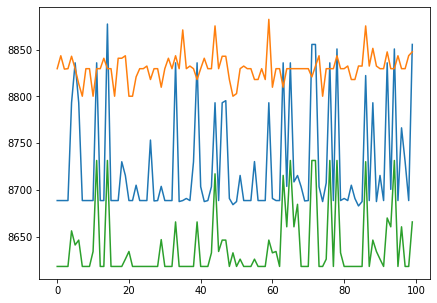

In [11]:
# agent = DQNAgent(templates, env=env, model_type=Net)
from a2c.a2c_agent import A2CAgent
import numpy as np
import yaml
from q_learning_agent import QTableAgent
with open('a2c/config.yaml') as f:
    templates = yaml.safe_load(f)
a2ca_agent = A2CAgent(templates, env)
# df_ac = env_summary(env, agent=a2ca_agent, random=False)
ga = GreedyAgent(env)
q_table_agent = QTableAgent(env,  episode_number=50000,  epsilon_delta=30000, mach_delta=0.01, checkpoint='saved_models/saved_12.npy')

# df_ac = env_summary(env, agent=agent, random=False)
# df_greedy = env_summary(env, agent=ga, random=False)
# df_qtable = env_summary(env, agent=q_table_agent , random=False)
# df_solver = env_summary(env, agent=solver_agent , random=False)
agents = [a2ca_agent, ga, q_table_agent]
fb = []
for j in js:
    fb.append(fa(env, j, agents))
fb = np.array(fb)
plt.plot(fb[:,0])
plt.plot(fb[:,1])
plt.plot(fb[:,2])

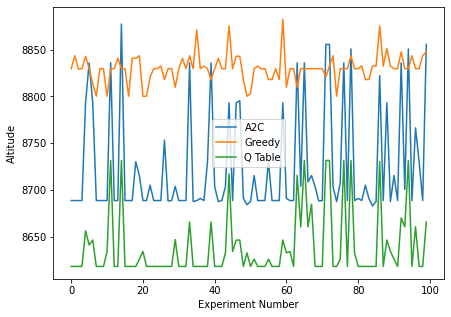

In [12]:
# plt.title("")
plt.plot(fb[:,0], label='A2C')
plt.plot(fb[:,1], label='Greedy')

plt.plot(fb[:,2], label='Q Table')
plt.legend()
plt.xlabel('Experiment Number')
plt.ylabel('Altitude')
# plt.savefig('Dynamic.png')
plt.show()

In [13]:
fb[:,0].mean(), fb[:,1].mean(), fb[:,2].mean()

(8725.10887053541, 8830.042593915987, 8638.81738731105)

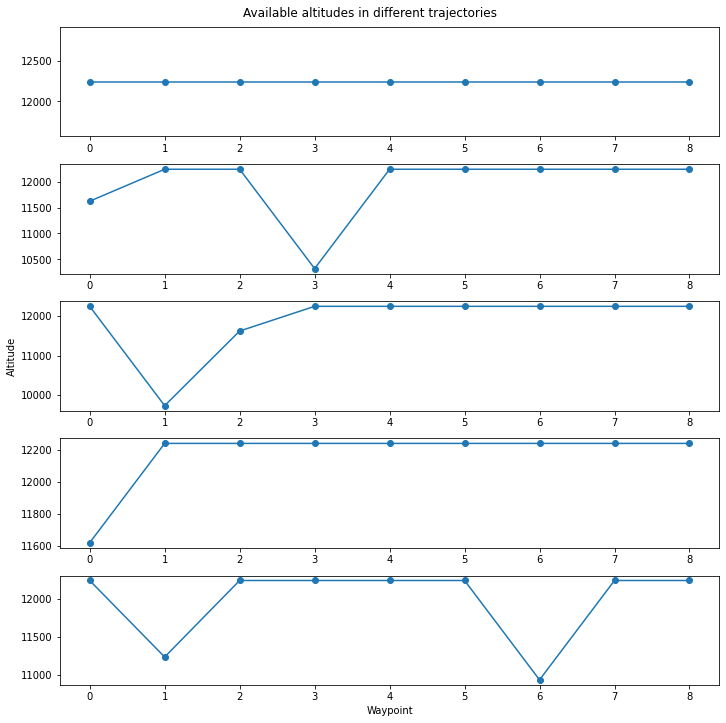

In [14]:
plt.rcParams["figure.figsize"] = (10,10)
fig, axes = plt.subplots(5, 1)
fig.suptitle('Available altitudes in different trajectories')

for i, ax in enumerate(axes):
    ax.plot(js[2][i], 'o-')
# ax.set_ylabel('Damped oscillation')
fig.tight_layout()
# ax2.plot(js[2][1], '.-')
axes[-1].set_xlabel('Waypoint')
axes[2].set_ylabel('Altitude')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.show()
fig.savefig('Available_Altitudes.png')

In [18]:
env = AircraftEnv(arrival_location=loc_1, destination=loc_2, n_waypoints=9)
agents = [a2ca_agent, ga, q_table_agent]
df_greedy = env_summary(env, agent=ga, to_env=True, random=False)
df_qtable = env_summary(env, agent=q_table_agent , to_env=True ,random=False)
df_ac = env_summary(env, agent=a2ca_agent, to_env=True, random=False)
df_solver = env_summary(env, agent=solver_agent , random=False)

In [19]:
env = AircraftEnv(arrival_location=loc_1, destination=loc_2, n_waypoints=9)
df_qtable['fuel_burn'].sum(), df_greedy['fuel_burn'].sum(), df_ac['fuel_burn'].sum(), df_solver['fuel_burn'].sum()

(8618.29762540234, 8829.624789241423, 8688.705899869994, 8671.041673413905)

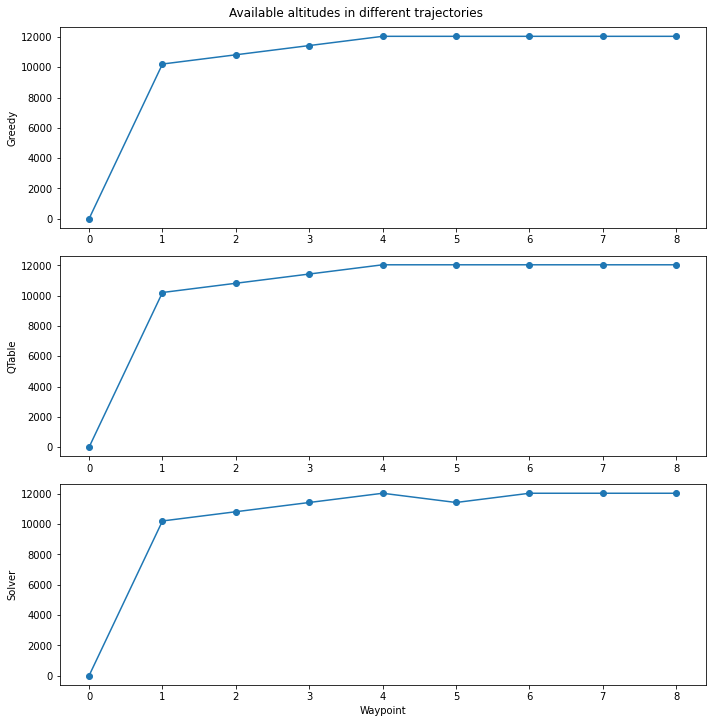

In [20]:
plt.rcParams["figure.figsize"] = (10,10)
fig, axes = plt.subplots(3, 1)
fig.suptitle('Available altitudes in different trajectories')
dfs = [df_greedy, df_qtable, df_solver]
names = ["Greedy", "QTable", "Solver"]
for i, ax in enumerate(axes):
    ax.set_ylabel(names[i])
    ax.plot(dfs[i]['altitude'], 'o-')
# ax.set_ylabel('Damped oscillation')
fig.tight_layout()
# ax2.plot(js[2][1], '.-')
axes[-1].set_xlabel('Waypoint')
# axes[2].set_ylabel('Altitude')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.show()
fig.savefig('Agents_Alt.png')

In [22]:
# import the library
import folium
import itertools
def add_points_to_map(m, waypoints, color='red'):
    for waypoint in waypoints:
        folium.CircleMarker(
            radius=1,
          location=[waypoint.latitude, waypoint.longitude],
    #       icon=folium.Icon(color="red",icon="star", prefix='fa')
            color=color
        ).add_to(m)
        
def _add_wind(m, wind_dir, wp_lat, wp_lon, wind):
    wind_lat, wind_lon = bearing2coords(wind_dir, wp_lat, wp_lon, 1000*wind)
    folium.PolyLine([[wp_lat, wp_lon], [wind_lat, wind_lon]], color="green", weight=1, opacity=3).add_to(m)
    folium.RegularPolygonMarker(location=[wind_lat, wind_lon], fill_color='green', number_of_sides=1, radius=1.5).add_to(m)
    
def add_winds(m, waypoints, winds_dirs, wind_magnitude):
    for i, wp in enumerate(waypoints):
        wind_dir = winds_dirs[len(winds_dirs) // 2][i]
        wind = wind_magnitude[len(wind_magnitude) // 2][i]
        _add_wind(m, wind_dir, wp.latitude, wp.longitude, wind)
        
def selected_trajectory(env: AircraftEnv, trajectory):
    return [env.waypoints[trajectory[i]][i] for i in range(len(trajectory))]
# Make an empty map

def show_map(df):
    m = folium.Map(location=env._waypoints_to_array()[env.n_routes // 2][env.n_waypoints // 2], tiles="OpenStreetMap", zoom_start=4, min_zoom=4, max_zoom = 6)
    locations = [loc_1, loc_2]
    ar_waypoints = env._waypoints_to_array()
    for loc in locations:

        folium.Marker(
          location=[loc.latitude, loc.longitude],
          popup=str(loc),
        ).add_to(m)
    # waypoints = env._waypoints_to_array()
    # new_route = list(itertools.chain(*[generate_new_route_2(env.waypoints[1:-1], x[0], x[1]) for x in [(90, 50e3), (90, 100e3), (270, 50e3), (270, 100e3)]]))

    for i, traj in enumerate(env.waypoints):
        color = 'blue' if i == env.n_routes // 2 else 'green'
        add_points_to_map(m, traj[1:-1], color=color)
        folium.PolyLine(ar_waypoints[i], color=color, weight=1, opacity=3).add_to(m)

    current_trajectory =  selected_trajectory(env, df['trajectory'])
    add_points_to_map(m, current_trajectory, color='red')
    folium.PolyLine([[wp.latitude, wp.longitude] for wp in current_trajectory], color='red', weight=1, opacity=3).add_to(m)
    return m
show_map(df_qtable)
# folium.PolyLine(ar_waypoints[i], color=color, weight=1, opacity=3).add_to(m)
# new_route = np.array([[wp.latitude, wp.longitude] for wp in new_route])


# folium.PolyLine(env._waypoints_to_array(), color="blue", weight=1, opacity=3).add_to(m)
# folium.PolyLine(new_route, color="red", weight=1, opacity=3).add_to(m)

# add_winds(m, env.main_trajectory, env._wind_direction, env._wind_magnitude)



In [23]:
show_map(df_greedy)

In [24]:
show_map(df_solver)